# Explorative Data Analysis

This notebook is the basis for the explorative data analysis for **Task 1.1**.

The task is as follows:

> Perform an exhaustive dataset analysis to explore the attributes of the TDT4265 dataset. The analysis should highlight commonalities, limitations and perhaps interesting samples in the dataset (both images and labels). You are free to choose how to present the analysis, and the analysis can be both statistical and qualitative. To get you started, you can try to analyze the size of the objects in the dataset.

For more information, these blog posts have been used for inspiration:
* [Popular Object Detection datasets - Analysis and Statistics](https://medium.com/@vijayshankerdubey550/popular-object-detection-datasets-analysis-and-statistics-66acdacc3aa9) (Medium article)
* [How to Do Data Exploration for Image Segmentation and Object Detection](https://neptune.ai/blog/data-exploration-for-image-segmentation-and-object-detection) (Neptune blog)
* [How to work with object detection datasets in COCO format](https://towardsdatascience.com/how-to-work-with-object-detection-datasets-in-coco-format-9bf4fb5848a4) (Medium article)
* [Visualizing Object Detections](https://medium.com/voxel51/visualizing-object-detections-9d0ed766297c) (Medium article)

This lead to the following points of interest:
* Intra-class variability (Low variability can be a limitation)
* Inter-class variability (distinguish between classes, while able to distinguish between high intra-class variability)
* Image size
* Class imbalance
* Object size to image size
* Background clutter (RCNN and FRCNN produces many false positives)
* Occlusion (The more occluded objects are the more difficult they are to detect)

And these interesting statistics:
* Number of objects per category
* Number of objects contained in a single image
* Size of the images present in the dataset
* Ratio of areas of Object size and Image size, for each object present in the image
* Overlap between objects

### Settings

In [1]:
# Autoimport changes in code
%load_ext autoreload
%autoreload 2

# Import system modules and include ../SSD in path
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))

# Set working directory to SSD folder
# NB! Running this cell several times will continue to move upwards in the directories.
print('Working directory:')
%cd ../

# Third party libraries
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from ssd import utils

# Local libraries
from dataset_exploration.dataset_statistics import (
    get_config,
    get_dataloader,
)

# Set seed
np.random.seed(0)

/Users/mariu/dev/school/TDT4265/project/computer-vision-and-deep-learning/SSD


### Load Dataset

Only the training data will be used in the statistical analysis.

In [3]:
# Load config
cfg = get_config(config_path="configs/tdt4265.py")

# Get dataloader
dataloader = get_dataloader(cfg, dataset_to_analyze="train")

Saving SSD outputs to: outputs/


In [12]:
# Verify that the dataset is available
dataset_obj = dataloader.dataset

### Visualize dataset

Using fiftyone we can visualize the dataset. The session can be started by running:

```
session = fo.launch_app(dataset_fo)
```

To take screenshots run:

```
session.freeze()
```

In [205]:
import fiftyone as fo

data_path = 'data/tdt4265_2022/'
labels_path = 'data/tdt4265_2022/train_annotations.json'

# Fiftyone version of dataset
dataset_fo = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=labels_path,
    name='tdt4265-dataset',
)

 100% |███████████████| 1604/1604 [6.0s elapsed, 0s remaining, 333.3 samples/s]      


## Statistics

Exploring statistics such as:
* Number of objects per category
* Number of objects contained in a single image
* Size of the images present in the dataset
* Ratio of areas of Object size and Image size, for each object present in the image
* Overlap between objects

In [217]:
# Get basic information
label_map = dataset_obj.label_info

# Get data and unwrap
data = dataset_obj.data
annotations, images, categories = data['annotations'], data['images'], data['categories']

In [218]:
# Calculate number of objects per category
categories_count = {i: 0 for i in range(1, len(categories) + 1)}

for annotation in annotations:
    category_id = annotation['category_id']
    categories_count[category_id] += 1

In [220]:
# Interestingly enough, this line does the same as the one above:
counts_fo = dataset_fo.count_values("ground_truth.detections.label")

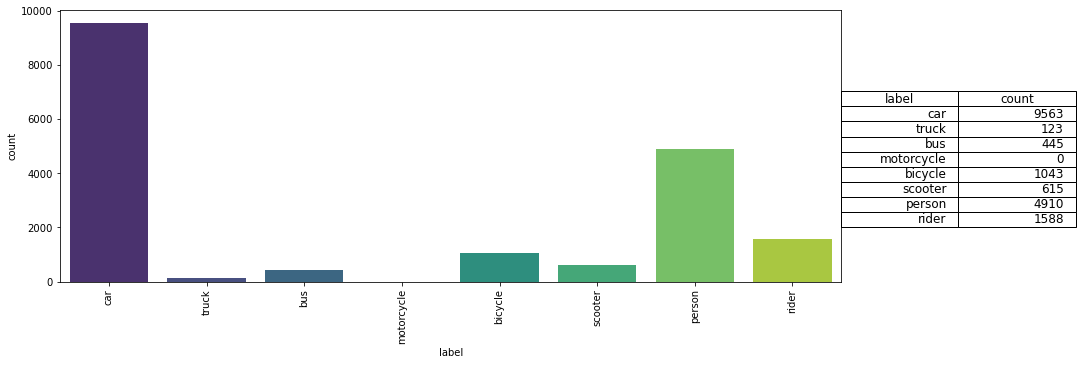

In [132]:
# Plot histogram and table

object_labels = {key: value for key, value in label_map.items() if key != 0}
df_categories = pd.DataFrame.from_dict([object_labels, categories_count]).T
df_categories.rename({0: 'label', 1: 'count'}, axis=1, inplace=True)

plt.figure(figsize=(14, 5))
sns.barplot(x='label', y='count', data=df_categories, palette='viridis')
plt.xticks(rotation=90)
table = plt.table(cellText=df_categories.values,
                  rowLabels=None,
                  colLabels=df_categories.columns,
                  cellLoc='right',
                  rowLoc='center',
                  loc='right',
                  bbox=[1., .2, .3, .5])
table.auto_set_font_size(False)
table.set_fontsize(12)
plt.show()

The dataset is clearly imbalanced. We see that *car* is the most represented class by far, only followed by *person*. This means it will be very difficult to train a good model to detect the other objects solely based on this dataset.

In [247]:
# Keys indicate number of objects in image, value is number of images with same number of objects
objects_per_image_dict = {}

for sample in dataset_fo:
    c = len(sample.ground_truth.detections)
    if c in objects_per_image_dict:
        objects_per_image_dict[c] += 1
    else:
        objects_per_image_dict[c] = 1

# check sum of dict
s = 0
for key, value in objects_per_image_dict.items():
    s += key * value

assert s == len(annotations), f'Expected: {len(annotations)}, got: {s}'

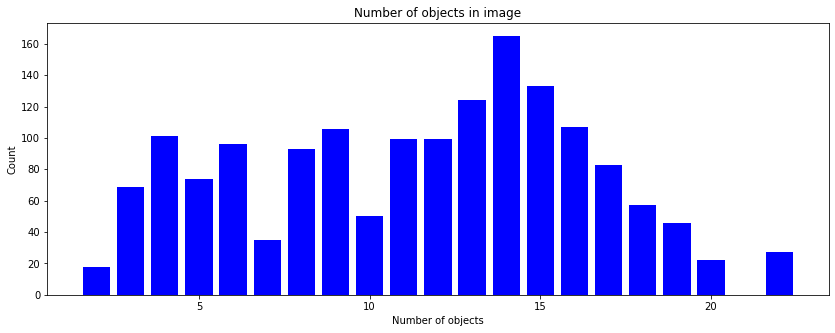

In [259]:
# Plot number of objects contained in an image
plt.figure(figsize=(14, 5))
# sns.barplot(x=list(objects_per_image_dict.keys()), y=list(objects_per_image_dict.values()), palette='viridis')
plt.bar(list(objects_per_image_dict.keys()), list(objects_per_image_dict.values()), color='blue')
plt.title('Number of objects in image')
plt.xlabel('Number of objects')
plt.ylabel('Count')
plt.show()

The majority of the images contains 14 objects (about 10%). Nonetheless, the histogram shows that most images contain 3 and 17 objects. This could impact model performance if the model learns that most images contains a certain number or range of number of objects.

In [260]:
# Calculate average number of objects in each image
average_objects_per_image = df_categories['count'].sum() / len(images)
print(f'Average number of objects per image: {average_objects_per_image:.2f}')

Average number of objects per image: 11.40


In [261]:
# Get image size
image_size = (images[0]['width'], images[0]['height'])
print(f'Image size: {image_size[0]} x {image_size[1]} (width x height)')

Image size: 1024 x 128 (width x height)


In [298]:
# Calculate ratio of areas of object size and image size, for each object present in each image

image_area = image_size[0] * image_size[1]

# Stores ratio of object area to image area
# key: int representation of float area, value: count of objects with that ratio
ratios_dict = {}

for sample in dataset_fo:
    bboxes = sample.ground_truth.detections
    for obj in bboxes:
        bbox = obj.bounding_box
        # Note, bounding boxes in fiftyone are represented as: [<top-left-x>, <top-left-y>, <width>, <height>]
        # Also, the coordinates are relative to the image size, not the image size divided by the bounding box size
        ratio = bbox[2] * bbox[3]
        if ratio in ratios_dict:
            ratios_dict[ratio] += 1
        else:
            ratios_dict[ratio] = 1


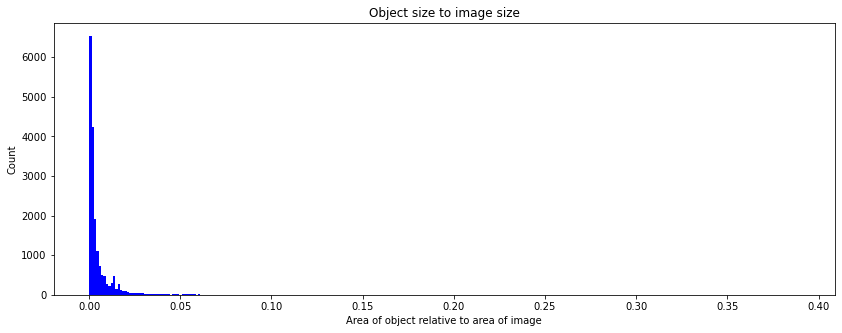

In [305]:
# Plot object ratios to image size
plt.figure(figsize=(14, 5))
# plt.hist(list(ratios_dict.keys()), list(ratios_dict.values()), bin=, color='blue')
ratios_as_list = [key for key, value in ratios_dict.items() for _ in range(value)]
plt.hist(ratios_as_list, bins=300, color='blue')
plt.title('Object size to image size')
plt.xlabel('Area of object relative to area of image')
plt.ylabel('Count')
plt.show()

The histogram confirms that most objects are small relative to the image size.

Overall the ratio is quite close to 0 for majority of the objects. This motivates us to crop the images into several patches and use it for training and inference, instead of resizing it to a smaller size, as used by the standard object detectors.

However, one should note that there exists images of buses covering 30-40% of the image. Again a case of samples that are difficult to train a model on with the current dataset.

In [311]:
# Measuring Overlap between objects in an image with IoU

# This is done by plotting IoU Area against Number of overlapping objects
# Hence, we have to calculate the IOU for each object in each image

from utils import calculate_iou

"""
Inputs for the calculate_iou function:

    prediction_box (np.array of floats): location of predicted object as
        [xmin, ymin, xmax, ymax]
    gt_box (np.array of floats): location of ground truth object as
        [xmin, ymin, xmax, ymax]

Note, bounding boxes in fiftyone are represented as: [<top-left-x>, <top-left-y>, <width>, <height>]
"""

def transform_bbox(bbox):
    # Transform to [xmin, ymin, xmax, ymax] from [<top-left-x>, <top-left-y>, <width>, <height>]
    return [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]

# key: IoU, value: count of objects that overlap with that IoU
iou_areas = {}

for sample in dataset_fo:
    bboxes = sample.ground_truth.detections
    for obj in bboxes:
        bbox = obj.bounding_box
        # For each bbox, calculate the IOU with all other bboxes in image
        for other_obj in bboxes:
            other_bbox = other_obj.bounding_box
            iou_area = calculate_iou(transform_bbox(bbox), transform_bbox(other_bbox))
            if iou_area in iou_areas:
                iou_areas[iou_area] += 1
            else:
                iou_areas[iou_area] = 1

# Remove self and no overlap
iou_areas.pop(0.0)
iou_areas.pop(1.0)

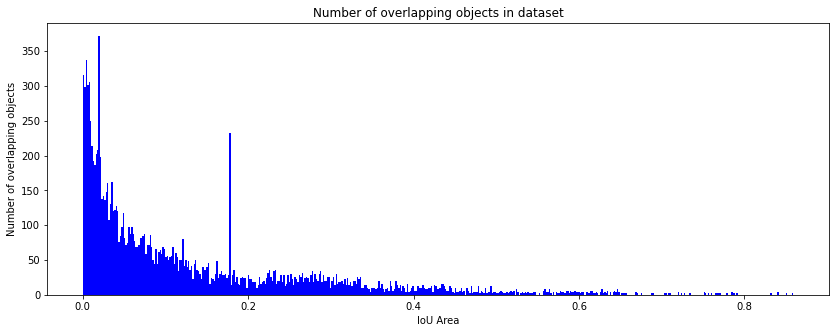

In [321]:
# Plot overlap between objects in an image with IoU
plt.figure(figsize=(14, 5))
ious_as_list = [key for key, value in iou_areas.items() for _ in range(value)]
plt.hist(ious_as_list, bins=500, color='blue')
plt.title('Number of overlapping objects in dataset')
plt.xlabel('IoU Area')
plt.ylabel('Number of overlapping objects')
plt.show()

The histogram above shows that there is a significant amount of overlap between objects in the dataset. The distribution is also long-tailed, indicated that there are a considerable amount of samples where there is more than 50% overlap between objects. This means the model will be trained on a lot of data without overlap, and only some with. Hence, augmenting with a focus on creating more crowds or overlaps could be valuable to increase the model performance when there are a lot of object overlaps. Other ideas for obtaining more information about objects with overlap could be to use Oriented Bounding Boxes (OBB).

In [306]:
# Check these out after finishing next section
#TODO: Calculate object size data for each class? Or do we have enough?
#TODO: Intra- and inter-class variability - We could do several of the current analyses on individual classes.

## Qualitative analysis

Until now we have looked at certain statistics of the dataset (images, objects and labels). In this section we extend our scope by looking at uniqueness and similarity between images. We also try to highlight some of the edge cases based on the information obtained above (e.g. smallest and greatest objects).

In [159]:
# Fiftyone imports
import fiftyone as fo
from fiftyone import ViewField as F
import fiftyone.brain as fob

In [281]:
# Start session
session = fo.launch_app(dataset_fo)

In [294]:
# Filter to only view small objects
# Bboxes are in [top-left-x, top-left-y, width, height] format
bbox_area = F("bounding_box")[2] * F("bounding_box")[3]

small_obj_view = dataset_fo.filter_labels(
  "ground_truth", 
  bbox_area > 0.37,
)

session.view = small_obj_view

In [160]:
# Find most unique samples in dataset
fob.compute_uniqueness(dataset_fo)

Computing embeddings...
 100% |███████████████| 1604/1604 [37.2s elapsed, 0s remaining, 41.3 samples/s]      
Computing uniqueness...
Uniqueness computation complete



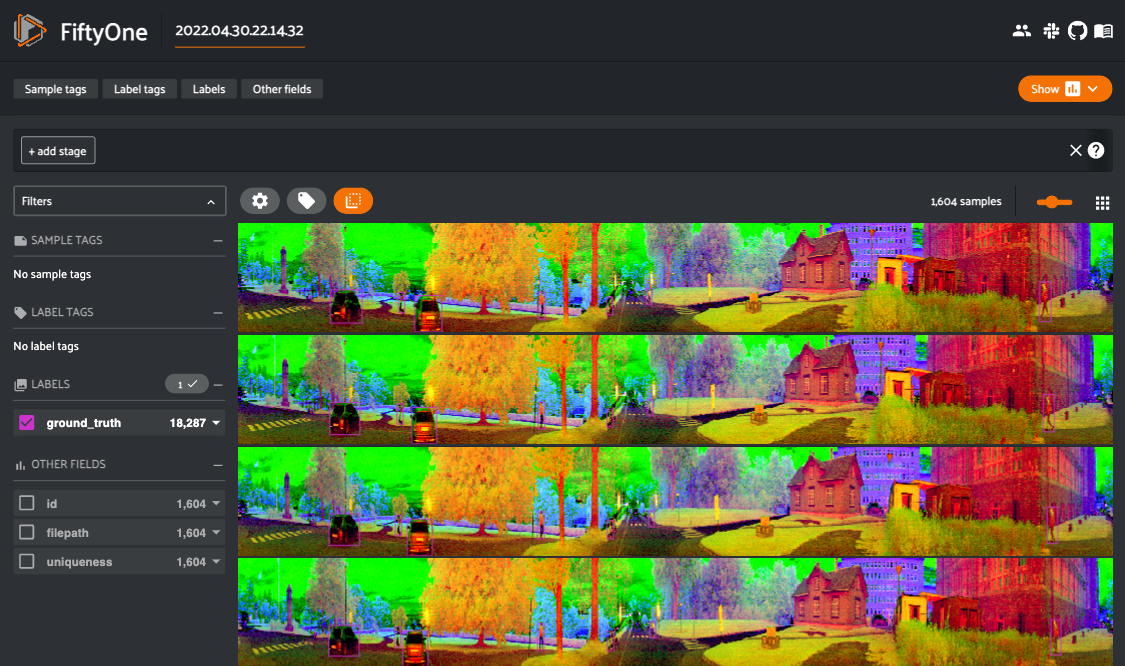

In [163]:
dups_view = dataset_fo.sort_by("uniqueness")

session.view = dups_view

### Visual similarity

How can visual simiarlity be used in practice? A common pattern is to mine your dataset for similar examples to certain images or object patches of interest, e.g., those that represent failure modes of a model that need to be studied in more detail or underrepresented classes that need more training examples.

Here are a few of the many possible applications:
 * Identifying failure patterns of a model
 * Finding examples of target scenarios in your data lake
 * Mining hard examples for your evaluation pipeline
 * Recommending samples from your data lake for classes that need additional training data
 * Pruning near-duplicate images from your training dataset

In [164]:
# Index images by similarity
fob.compute_similarity(dataset_fo, brain_key="image_sim")

 100% |████|  108.4Mb/108.4Mb [1.1s elapsed, 0s remaining, 100.9Mb/s]        
Computing embeddings...
 100% |███████████████| 1604/1604 [5.4m elapsed, 0s remaining, 4.9 samples/s]       


Generating index...
Index complete



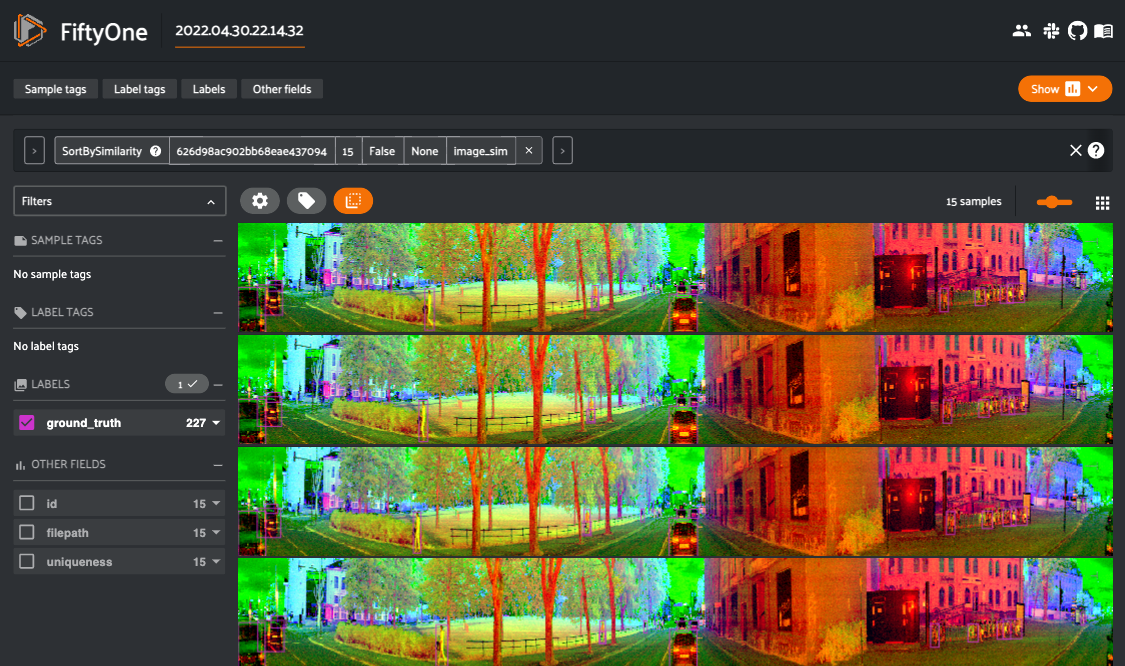

In [166]:
# Choose a random image from the dataset
query_id = dataset_fo.take(1).first().id

# Programmatically construct a view containing the 15 most similar images
view = dataset_fo.sort_by_similarity(query_id, k=15, brain_key="image_sim")

# View results in App
session.view = view

In [ ]:
# Visualizing uniqueness

# Compute embeddings via a pre-trained CIFAR-10 classifier
model = fbm.load_model("simple-resnet-cifar10")
embeddings = dataset.compute_embeddings(model, batch_size=16)

# Generate similarity index
results = fob.compute_similarity(
    dataset, embeddings=embeddings, brain_key="img_sim"
)

# Generate a 2D visualization
viz_results = fob.compute_visualization(
    dataset, embeddings=embeddings, brain_key="img_viz"
)

In [ ]:
# Use the similarity index to identify 500 maximally unique images
results.find_unique(500)
print(results.unique_ids[:5])

In [ ]:
# Visualize the unique images in embeddings space
plot = results.visualize_unique(visualization=viz_results)
plot.show(height=800, yaxis_scaleanchor="x")

In [ ]:
# Visualize the unique images in the App
unique_view = dataset.select(results.unique_ids)
session = fo.launch_app(view=unique_view)

In [ ]:
# Use the similarity index to identify the 1% of images that are least
# visually similar w.r.t. the other images
results.find_duplicates(fraction=0.01)

print(results.neighbors_map)

In [ ]:
duplicates_view = results.duplicates_view(
    type_field="dup_type",
    id_field="dup_id",
    dist_field="dup_dist",
)

session.view = duplicates_view

In [167]:
# Index ground truth objects by similarity
fob.compute_similarity(
    dataset_fo, patches_field="ground_truth", brain_key="gt_sim"
)

Computing patch embeddings...
   0% ||--------------|    0/1604 [39.7ms elapsed, ? remaining, ? samples/s] 

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


 100% |███████████████| 1604/1604 [21.8m elapsed, 0s remaining, 4.4 samples/s]      



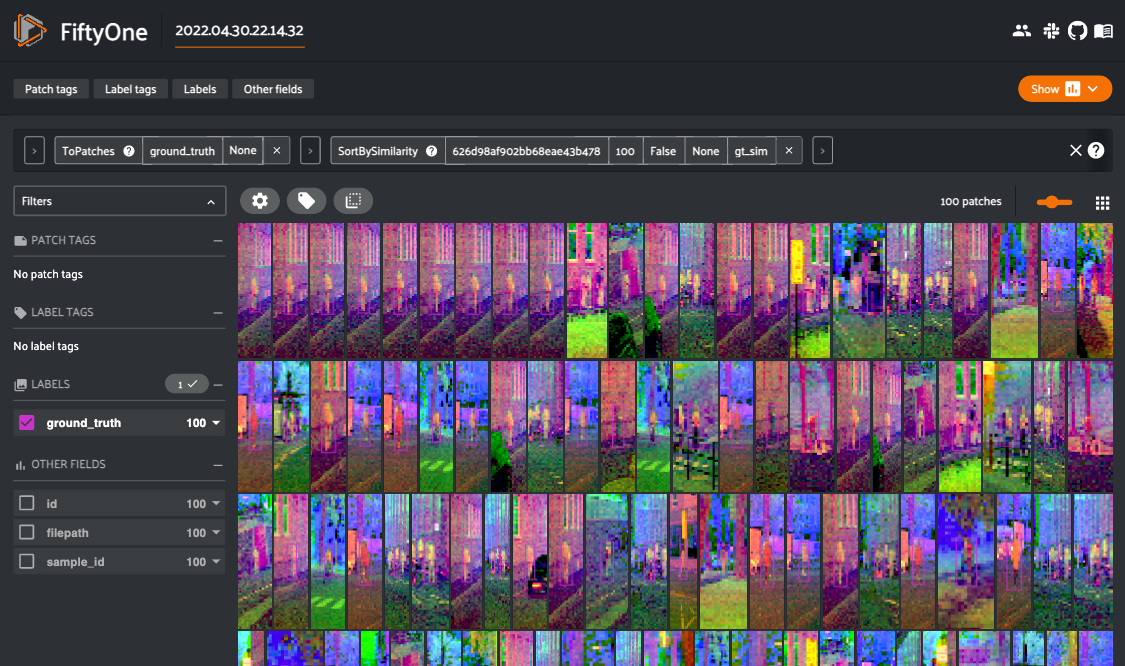

In [169]:
# Convert to patches view
patches = dataset_fo.to_patches("ground_truth")

# Choose a random patch object from the dataset
query_id = patches.take(1).first().id

# Programmatically construct a view containing the 100 most similar objects
view = patches.sort_by_similarity(query_id, k=100, brain_key="gt_sim")

# View results in App
session.view = view

In [ ]:
# Find sample hardness

fob.compute_hardness(dataset_fo, "predictions")